# Treść zadania
* Rozpoznawanie gestów liczenia na palcach

In [2]:
#  importy
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers as tfl
import os
import cv2
from sklearn import preprocessing
from pathlib import Path
from PIL import Image

import math
import seaborn as sns
import matplotlib.patches as pat
from skimage import io
import skimage as si
import skimage.filters as sif
import skimage.segmentation as sis
import skimage.measure as sime
import skimage.morphology as simo
import skimage.color as sic

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

# Wstępne przetwarzanie danych

Zdjęcia znajdują się w folderach "train" i "test" 
* Zapisanie do dwóch list 'train_set_path' i 'test_set_path' ścieżek do konkretnych zdjęć z odpowiednich folderów "train" i "test"
* Zapisanie do dwóch list 'train_set_label' i 'test_set_label' etykiet konkretnych zdjęć z odpowiednich folderów "train" i "test" przez oddzielenie w od nazwy pliku dwóch ostatnich znaków przed znakiem '.'
Np: /fingers/test/ef512789-23fb-4da6-ad2e-38780d9cd914_**1L**.png

In [3]:
#funkcja zwracająca listę ścieżek do zdjęć i etykiet na podstawie nazw plików
def extract_label(base):
    path = [] #lista ścieżek
    label = [] #lista etykiet
    for filename in os.listdir(base):
        label.append(filename.split('.')[0][-2:]) #odzielenie nazwy pliku od rozszerzenia oraz dodanie dwóch ostatnich znakównazwy pliku do listy etykiet 
        path.append(base+filename) #dodanie ścięzki zdjęcia do listy ścieżek
    return path, label

In [4]:
#ścieżka do folderów treningowego i testującego
train_base = "fingers/train/"
test_base = "fingers/test/"

#listy przechowujące: 1. ścieżki do plików 2. etykiety
train_set_path, train_set_label = extract_label(train_base)
test_set_path, test_set_label = extract_label(test_base)

#wypisanie liczby zdjęć zestawów
print("Liczba zdjęć zestawu treningowego: ", len(train_set_path))
print("Liczba zdjęć zestawu testującego: ", len(test_set_path))

Liczba zdjęć zestawu treningowego:  18000
Liczba zdjęć zestawu testującego:  3600


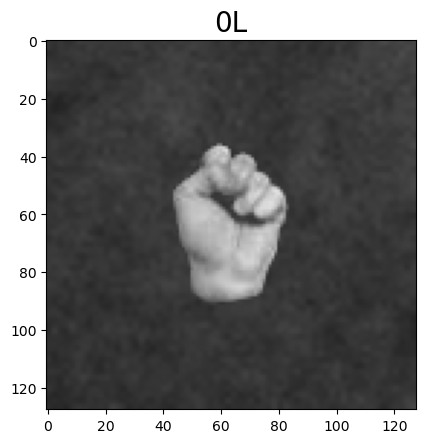

In [5]:
#wczytanie pierwszego zdjęcia zestawu treningowego
index=0
image = cv2.imread(train_set_path[index]) 

# wyświetlenie zdjęcia wrac z etykietą
plt.imshow(image)
plt.title(train_set_label[index], fontsize = 20)
plt.show()

# Funkcja zapisująca zdjęcia 

Funkcja zapisująca zdjęcia z folderów "train" i "test" odpowiednio do list X_train i X_test

In [6]:
# funkcja zapisująca do listy zdjęcia na podstawie ścieżek zapisanych w podanej liście
def feature_data_split(path):
    feature_set = []
    for p in path:
        image = cv2.imread(p)
        feature_set.append(image)
    return feature_set

In [7]:
# wczytanie zdjęć do list
X_train = feature_data_split(train_set_path)
X_test = feature_data_split(test_set_path)

# skonwertowanie list do numpy array
X_train = np.array(X_train)
X_test = np.array(X_test)

# sprawdzenie shape skonwertowanych tablic
print(X_train.shape) # format: (liczba zdjęć, wysokość zdjęcia, szerokość zdjęcia, liczba kanałów)
print(X_test.shape)  # format: (liczba zdjęć, wysokość zdjęcia, szerokość zdjęcia, liczba kanałów)

(18000, 128, 128, 3)
(3600, 128, 128, 3)


# Eksploracja danych

In [164]:
attribute_table = ['EulerNumber', 'Area', 'Eccentricity', 'Orientation', 'BoundingBoxArea', 'Perimeter', 'axis_major_length', 'axis_minor_length', 'equivalent_diameter_area']
photo_attribs = pd.DataFrame(columns = attribute_table)
photo_attribs['CorrectLabel'] = ""
# photo_attribs['GivenLabel'] = ""

,EulerNumber,Area,Eccentricity,Orientation,BoundingBoxArea,Perimeter,axis_major_length,axis_minor_length,equivalent_diameter_area,CorrectLabel


In [165]:
n_attrbs = len(attribute_table)
n_photos = X_train.shape[0]
x=0
for i in range(n_photos):
    image = X_train[i]
    gray_image = sic.rgb2gray(image)
    blurred_image = sif.gaussian(gray_image, sigma=1)
    threshold = sif.threshold_otsu(blurred_image)
    binarny = blurred_image > threshold
    hand_label = sime.label(binarny)
    attrbs = sime.regionprops(hand_label)
    biggest_index=0
    if(len(attrbs) != 1):
        sizes = []
        for j in range(len(attrbs)):
            sizes.append(attrbs[j]['Area'])
        biggest_index = sizes.index(max(sizes))
    record = dict()
    for j in range(n_attrbs):
        record[attribute_table[j]] = attrbs[biggest_index][attribute_table[j]]
    record['CorrectLabel'] = train_set_label[i]
    new_row = pd.Series(record)
    photo_attribs = pd.concat([photo_attribs, new_row.to_frame().T], ignore_index =True)

photo_attribs

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000


,EulerNumber,Area,Eccentricity,Orientation,BoundingBoxArea,Perimeter,axis_major_length,axis_minor_length,equivalent_diameter_area,CorrectLabel
0,0,1387,0.73127,0.038786,2106,218.651804,54.270071,37.016989,42.023603,0L
1,-2,1180,0.762747,0.150032,1813,202.787843,51.120082,33.05923,38.761097,0L
2,0,2039,0.898564,0.139923,3485,310.793939,85.584591,37.558186,50.952286,2L
3,0,1272,0.616587,-0.158032,2150,228.829473,50.485317,39.746428,40.243766,0L
4,1,2498,0.720952,-0.486556,7134,436.404112,81.395761,56.406074,56.396386,5L
...,...,...,...,...,...,...,...,...,...,...
17995,-2,1201,0.766299,0.138887,1800,200.651804,51.316503,32.970021,39.104484,0L
17996,0,2106,0.773305,-0.049202,4560,410.918831,76.274408,48.360628,51.782647,4L
17997,0,1432,0.715844,-0.314741,2132,216.166522,54.326968,37.934363,42.699872,0R
17998,0,1932,0.87654,0.025646,3321,294.208153,80.635905,38.812444,49.597367,2L


# Etykietowanie Train/Test

* Wykorzystanie LabelEncoder z sklearn do konwersji etykiet do unikatowych wartości int
* Wykorzystanie biblioteki Keras do zapisania unikatowych wartości za pomocą kodu 1 z n i zapisanie do binarnej macierzy reprezentacji etykiet zbioru

In [64]:
# sprawdzenie unikatowych wartości list etykiet
print("Unikatowe wartości listy etykit zestawu treningowego: ", list(np.unique(train_set_label)))
print("Unikatowe wartości listy etykit zestawu testowego: ", list(np.unique(test_set_label)))
if len(np.unique(train_set_label)) == len(np.unique(test_set_label)): # sprawdzenie czy jest tyle samo wartości unikatowych w listach etykiet zestawów treningowego i testowego
  print("Liczba unikatowych etykiet (klas): ", len(np.unique(train_set_label)))
  num_classes = len(np.unique(train_set_label)) # zapisanie liczby unikatowych etykiet

Unikatowe wartości listy etykit zestawu treningowego:  ['0L', '0R', '1L', '1R', '2L', '2R', '3L', '3R', '4L', '4R', '5L', '5R']
Unikatowe wartości listy etykit zestawu testowego:  ['0L', '0R', '1L', '1R', '2L', '2R', '3L', '3R', '4L', '4R', '5L', '5R']
Liczba unikatowych etykiet (klas):  12


In [65]:
# zakodowanie etykiet - konwersja etykiet do unikatowych wartości n=int
y_train = preprocessing.LabelEncoder().fit_transform(train_set_label)
y_test = preprocessing.LabelEncoder().fit_transform(test_set_label)

print("Unikatowe wartości zakodowanych etykiet zestawu treningowego: ", np.unique(y_train))
print("Unikatowe wartości zakodowanych etykiet zestawu testującego: ", np.unique(y_test))
if len(np.unique(y_train)) == len(np.unique(y_test)): # sprawdzenie czy jest tyle samo wartości unikatowych w listach zakodowanych etykiet zestawów treningowego i testowego
  print("Liczba unikatowych wartości zakodowanych etykiet: ", len(np.unique(y_train)))
  num_classes = len(np.unique(y_train)) # zapisanie liczby unikatowych zakodowanych etykiet

Unikatowe wartości zakodowanych etykiet zestawu treningowego:  [ 0  1  2  3  4  5  6  7  8  9 10 11]
Unikatowe wartości zakodowanych etykiet zestawu testującego:  [ 0  1  2  3  4  5  6  7  8  9 10 11]
Liczba unikatowych wartości zakodowanych etykiet:  12


In [66]:
# przekształcenie listy na macierz z wykorzystaniem kodu 1 z n
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(y_train.shape) # format: (liczba zdjęć, liczba etykiet)
print(y_test.shape) # format: (liczba zdjęć, liczba etykiet)

(18000, 12)
(3600, 12)


AttributeError: 'numpy.ndarray' object has no attribute 'head'